# Installation des librairies 

In [ ]:
!pip install  visualkeras
!pip3 install ann_visualizer
!pip install graphviz

# Chargement des librairies

In [ ]:
import numpy as np 
import pandas as pd 
import random
np.random.seed(42)

from sklearn.metrics import classification_report, confusion_matrix
import sklearn.model_selection

import keras
from keras import layers

import tensorflow as tf 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.applications import EfficientNetB0

import os
from glob import glob

import matplotlib.pyplot as plt 
import seaborn as sns
import visualkeras

from PIL import Image

from datetime import datetime


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Expolation des donnees

In [ ]:
dir = '/content/drive/MyDrive/AI/A62/input/chest_xray/chest_xray'
test_dir  = os.path.join(dir,'test') 
train_dir = os.path.join(dir,'train') 
val_dir   = os.path.join(dir,'val') 

## Nombre des images par class

In [ ]:
NumClass = len(glob(train_dir+"/*")) 
print("Number of Classes: ",NumClass)

Number of Classes:  2


In [ ]:
categ = ['NORMAL', 'PNEUMONIA']

In [ ]:
number_classes_train = {categ[0]: len(os.listdir((os.path.join(train_dir,categ[0])))),
categ[1]: len(os.listdir((os.path.join(train_dir,categ[1]))))}
number_classes_test = {categ[0]: len(os.listdir(os.path.join(test_dir,categ[0]))),
categ[1]: len(os.listdir(os.path.join(test_dir,categ[1])))}
number_classes_val = {categ[0]: len(os.listdir(os.path.join(val_dir,categ[0]))),
categ[1]: len(os.listdir(os.path.join(val_dir,categ[1])))}

In [ ]:
print('Train      ',number_classes_train)
print('Test       ',number_classes_test)
print('Validation ',number_classes_val)

Train       {'NORMAL': 1341, 'PNEUMONIA': 3875}
Test        {'NORMAL': 234, 'PNEUMONIA': 390}
Validation  {'NORMAL': 8, 'PNEUMONIA': 8}


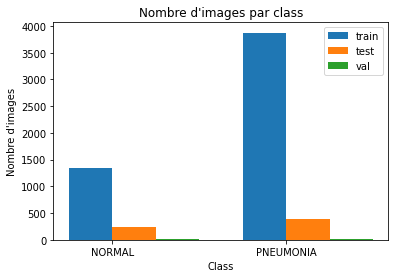

In [ ]:
N = 2
r = np.arange(N) 
width=0.25
plt.bar(r, number_classes_train.values(), width = .25,label='train');
plt.bar(r+width, number_classes_test.values(), width = .25,label='test');
plt.bar(r+2*width, number_classes_val.values(), width = .25,label='val');
plt.title("Nombre d'images par class");
plt.xlabel('Class');
plt.ylabel("Nombre d'images");
plt.xticks(r + width/2,['NORMAL', 'PNEUMONIA'])
plt.legend()
plt.show()


## Affichage des images aleatoires pour train, test et val dans chaque categorie

In [ ]:
def listdir_nohidden(path):
    for f in os.listdir(path):
        if not f.startswith('.'):
            yield f

NORMAL


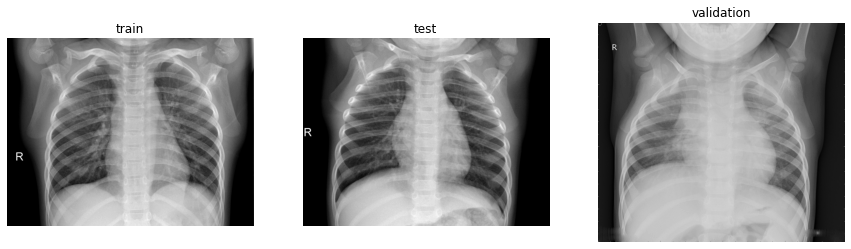

PNEUMONIA


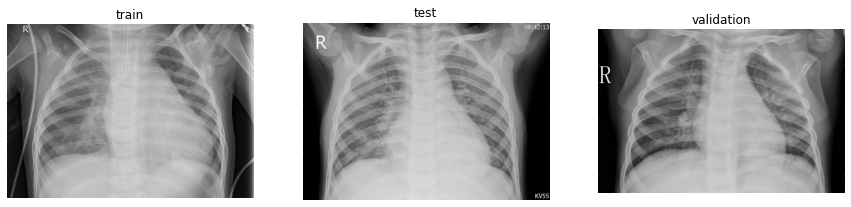

In [ ]:
categ = ['NORMAL', 'PNEUMONIA']
dirs =[train_dir,test_dir,val_dir]
titles=['train','test','validation']

for ca in categ:
    plt.figure(figsize=(15,10))
    print(ca)
    i = 0
    for d in dirs:
      path = os.path.join(d,ca)
      files=os.listdir(path)
      img=random.choice(files)
      img_arr =Image.open(os.path.join(path,img)) 
      plt.subplot(1, 3, i + 1)
      plt.imshow(np.array(img_arr),cmap='gray')
      plt.title(titles[i])
      plt.axis('off')
      i=i+1

    plt.show() 

Affichage des images reduits pour voir si on perde beaucoup d'information ou non

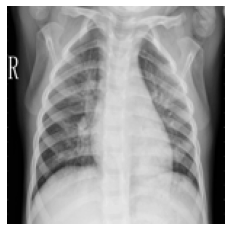

In [ ]:
img_size = 150
new_img = img_arr.resize((img_size,img_size))
plt.imshow(new_img,cmap='gray')
plt.axis('off')
plt.show()

## La taille des images originales

In [ ]:
categ = ['NORMAL', 'PNEUMONIA']
longeur_train=[]
largeur_train=[]
y_train=[]
longeur_test=[]
largeur_test=[]
y_test=[]
longeur_val=[]
largeur_val=[]
y_val=[]
for ca in categ:
    class_num = categ.index(ca)
    path = os.path.join(train_dir,ca)
    files=list(listdir_nohidden(path))
    for i in os.listdir(path):
        img_arr =Image.open(os.path.join(path,i)) 
        arr = np.array(img_arr)
        y_train.append(class_num)
        largeur_train.append(arr.shape[0])
        longeur_train.append(arr.shape[1])   
    #test   
    path = os.path.join(test_dir,ca)
    files=list(listdir_nohidden(path))
    for i in files:
       img_arr =Image.open(os.path.join(path,i)) 
       arr = np.array(img_arr)
       y_test.append(class_num)
       largeur_test.append(arr.shape[0])
       longeur_test.append(arr.shape[1])   
    #val   
    path = os.path.join(val_dir,ca)
    files=list(listdir_nohidden(path))
    for i in files:
       img_arr =Image.open(os.path.join(path,i)) 
       arr = np.array(img_arr)
       y_val.append(class_num)
       largeur_val.append(arr.shape[0])
       longeur_val.append(arr.shape[1])  
#-----MIN MAX
print('TRAIN')       
print('Longeur min :',min(longeur_train),'Longeur max :',max(longeur_train))    
print('Largeur min :',min(largeur_train),'Largeur max :',max(largeur_train))              

print('TEST')       
print('Longeur min :',min(longeur_test),'Longeur max :',max(longeur_test))    
print('Largeur min :',min(largeur_test),'Largeur max :',max(largeur_test))              

print('VALIDATION')       
print('Longeur min :',min(longeur_val),'Longeur max :',max(longeur_val))    
print('Largeur min :',min(largeur_val),'Largeur max :',max(largeur_val))

TRAIN
Longeur min : 384 Longeur max : 2916
Largeur min : 127 Largeur max : 2663
TEST
Longeur min : 728 Longeur max : 2752
Largeur min : 344 Largeur max : 2713
VALIDATION
Longeur min : 968 Longeur max : 1776
Largeur min : 592 Largeur max : 1416


In [ ]:
dim_df_train = pd.DataFrame(data=np.column_stack((largeur_train,longeur_train,y_train)), columns=['height', 'width','category'])
dim_df_train.plot.scatter(x='width', y='height',edgecolors='r', c=y_train,title='train');

dim_df_test = pd.DataFrame(data=np.column_stack((largeur_test,longeur_test,y_test)), columns=['height', 'width','category'])
dim_df_test.plot.scatter(x='width', y='height',edgecolors='r', c=y_test,title='test');

dim_df_val = pd.DataFrame(data=np.column_stack((largeur_val,longeur_val,y_val)), columns=['height', 'width','category'])
dim_df_val.plot.scatter(x='width', y='height',edgecolors='r', c=y_val,title='val');

None

# Pre-traitement de donnees


##  Chargement des donnees dans les lists

- La majorite des images sont en mode 'L', mais il y a encore quelques images en mode 'RGB'. Donc, on a converti tous les images en mode 'L' et resize avant les sauvegarder en list 

In [ ]:
def create_list(my_list,categ,my_dir,img_size):
    for ca in categ:
        path = os.path.join(my_dir,ca)
        class_num = categ.index(ca)
        for img in os.listdir(path):
            img_arr =Image.open(os.path.join(path,img)) 
            img_arr1 = img_arr.convert("L")            
            new_im = img_arr1.resize((img_size,img_size))
            new_img = np.asarray(new_im)
            arr = new_img.reshape((img_size, img_size, 1))
            my_list.append([arr,class_num])      
       

In [ ]:
img_size=150
train_list = []
test_list = []
val_list = []
create_list(train_list,categ,train_dir,img_size)
create_list(test_list,categ,test_dir,img_size)
create_list(val_list,categ,val_dir,img_size)
print('Taille de donnees de train: ', len(train_list))
print('Taille de donnees de test: ',len(test_list))
print('Taille de donnees de validation: ', len(val_list))

Taille de donnees de train:  5216
Taille de donnees de test:  624
Taille de donnees de validation:  16


## Split les donnees (X - image; y - etiquette)

In [ ]:
def split_data(X,y,my_list,img_size):
    for i,j in my_list:
        X.append(i)
        y.append(j)
    X = np.array(X).reshape(-1, img_size, img_size, 1)

In [ ]:
X_train = []
y_train = []
X_test = []
y_test = []
X_val = []
y_val = []
split_data(X_train, y_train, train_list, img_size)

In [ ]:
split_data(X_test, y_test, test_list, img_size)

In [ ]:
split_data(X_val, y_val, val_list, img_size)

In [ ]:
X_train = np.asarray(X_train)
y_train = np.asarray(y_train)
X_test = np.asarray(X_test)
y_test = np.asarray(y_test)
X_val = np.asarray(X_val)
y_val = np.asarray(y_val)

In [ ]:
# Verification double
print('Donnees de TRAIN')
print('Normal :', np.unique(y_train, return_counts=True)[1][0])
print('Pneumonie :',np.unique(y_train, return_counts=True)[1][1])
print('-----')
print('Donnees de TEST')
print('Normal :', np.unique(y_test, return_counts=True)[1][0])
print('Pneumonie :',np.unique(y_test, return_counts=True)[1][1])
print('-----')
print('Donnees de VALIDATION')
print('Normal :', np.unique(y_val, return_counts=True)[1][0])
print('Pneumonie :',np.unique(y_val, return_counts=True)[1][1])


Donnees de TRAIN
Normal : 1341
Pneumonie : 3875
-----
Donnees de TEST
Normal : 234
Pneumonie : 390
-----
Donnees de VALIDATION
Normal : 8
Pneumonie : 8


## Normalisation des images

In [ ]:
X_train = X_train/255.0
X_test = X_test/255.0
X_val = X_val/255.0

# Developpement du Modele

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor = 'val_loss', patience = 10, restore_best_weights=True)

In [ ]:
print(X_train.shape)

(5216, 150, 150, 1)


### Definition du modele
- On va utiliser le modele ResNet pre-entraine.
- Optimisateur 'Adam'
- Fonction loss 'binary_crossentropy'
- Utilisation de 'callbacks' pour debarasser de overfit

In [ ]:
inputs = keras.Input(shape=(img_size, img_size, 1))

# data augmentation
x = tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal')(inputs)
x = tf.keras.layers.experimental.preprocessing.RandomTranslation(height_factor=0.20, width_factor=0.20)(x)
x = tf.keras.layers.experimental.preprocessing.RandomRotation(factor=0.09)(x)


def res_net_block(input_data, filters, conv_size):
    x = layers.Conv2D(filters, conv_size, activation='relu', padding='same')(input_data)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(filters, conv_size, activation=None, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Add()([x, input_data])
    x = layers.Activation('relu')(x)
    return x

# model itself
x = keras.layers.Conv2D(filters=64, kernel_size=3, input_shape=(img_size, img_size, 1), padding='same', activation="relu")(x)
x = keras.layers.Conv2D(filters=32, kernel_size=3, input_shape=(64, 64, 1), padding='same', activation="relu")(x)
num_res_net_blocks = 18
for i in range(num_res_net_blocks):
    x = res_net_block(x, 32, 5)
x = layers.Dropout(0.5)(x)
for i in range(num_res_net_blocks):
    x = res_net_block(x, 32, 5)
x = layers.Conv2D(25, 3, activation='relu')(x)
x = layers.GlobalMaxPooling2D()(x)
x = keras.layers.Dense(256, activation='sigmoid')(x)
x = keras.layers.Dense(32, activation='sigmoid')(x)

outputs = layers.Dense(1, activation='sigmoid')(x)

model = keras.Model(inputs, outputs)

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer = tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 1  0           []                               
                                )]                                                                
                                                                                                  
 random_flip (RandomFlip)       (None, 150, 150, 1)  0           ['input_1[0][0]']                
                                                                                                  
 random_translation (RandomTran  (None, 150, 150, 1)  0          ['random_flip[0][0]']            
 slation)                                                                                         
                                                                                              

## Visualization de notre modele

In [ ]:
visualkeras.layered_view(model)

## Fit du modele

In [ ]:
start_CNN = datetime.now()

In [ ]:
history=model.fit(X_train, y_train, epochs=150, batch_size=32, validation_data=(X_test,y_test), callbacks=[early_stop])

Epoch 1/150
163/163 [==============================] - 16395s 101s/step - loss: 0.4933 - accuracy: 0.7467 - val_loss: 0.7775 - val_accuracy: 0.3766
Epoch 2/150
163/163 [==============================] - 16247s 100s/step - loss: 0.4385 - accuracy: 0.7765 - val_loss: 1.2503 - val_accuracy: 0.6250
Epoch 3/150
163/163 [==============================] - 16245s 100s/step - loss: 0.4010 - accuracy: 0.8077 - val_loss: 1.0628 - val_accuracy: 0.6250
Epoch 4/150
163/163 [==============================] - 16190s 99s/step - loss: 0.3704 - accuracy: 0.8309 - val_loss: 1.0991 - val_accuracy: 0.6282
Epoch 5/150
104/163 [==================>...........] - ETA: 1:35:50 - loss: 0.3643 - accuracy: 0.8347

In [ ]:
end_CNN = datetime.now()
time_CNN = end_CNN - start_CNN 
print('Le temps pour faire le fit du modele :', time_CNN)

## Sauvgarder le modele

In [ ]:
model_file = "/content/drive/MyDrive/AI/A62/input/chest_xray/chest_xray/top_model_resnet_1.h5"
model.save(model_file)
print('Modele sauvegarde comme h5!')

In [ ]:
import pickle
model_file1 = 'top_model_resnet_1.pkl'
pickle.dump(model, open(model_file1, 'wb'))
print("Modele sauvegarde comme pkl!")

# Metriques du modele

## Les curbes de Perte et Accuracy

In [ ]:
plt.figure(figsize=(12, 8))

plt.subplot(1, 2, 1)
plt.title('Perte')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xlabel("Epoch")
plt.legend()

plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.xlabel("Epoch")
plt.legend()

plt.show()

In [ ]:
score = model.evaluate(X_val,y_val) 
print("Val Loss : ", score[0])
print("Val Accuracy : ", score[1])

In [ ]:
score = model.evaluate(X_test,y_test) 
print("Test Loss : ", score[0])
print("Test Accuracy : ", score[1])

In [ ]:
score = model.evaluate(X_train,y_train) 
print("Train Loss : ", score[0])
print("Train Accuracy : ", score[1])

## Matrice de confusion pour donnees de test

In [ ]:
y_pr = model.predict(X_test)
y_pred = np.argmax(y_pr, axis=1)

cm = confusion_matrix(y_test, y_pred)

print('Matrice de confusion')

ax = sns.heatmap(cm,  yticklabels = categ, xticklabels = categ, annot = True, fmt = "d", cmap = 'Reds')

ax.set_title('Matrice de confusion\n\n');
ax.set_xlabel('\n Les valuers predictes')
ax.set_ylabel('Valuers actuels ')

plt.show()

## Rapport de classification pour donnees de test

In [ ]:
print(classification_report(y_test, y_pred))

## Matrice de confusion pour donnees de train

In [ ]:
y_pr = model.predict(X_train)
y_pred = np.argmax(y_pr, axis=1)

cm = confusion_matrix(y_train, y_pred)

print('Matrice de confusion')

ax = sns.heatmap(cm,  yticklabels = categ, xticklabels = categ, annot = True, fmt = "d", cmap = 'Reds')

ax.set_title('Matrice de confusion\n\n');
ax.set_xlabel('\n Les valuers predictes')
ax.set_ylabel('Valuers actuels ')

plt.show()


## Rapport de classification pour donnees de train

In [ ]:
print(classification_report(y_train, y_pred))

# PRODUCTION MODEL

In [ ]:
from keras.models import load_model
import pickle
model_file1 = 'top_model_resnet_1.pkl'
pickle.dump(lm, open(model_file1, 'wb'))
print("Model saved to pkl!")

In [ ]:
filename = "/content/drive/MyDrive/AI/A62/input/chest_xray/chest_xray/top_model_resnet_1.pkl"
display(filename)

In [ ]:
# load model
model1 = pickle.load(open(filename, 'rb'))
# summarize model
#model1.summary()

In [ ]:
# Evaluer le modele
score_test = model1.evaluate(X_test, y_test, verbose=0)
print(" TEST  %s: %.2f%%" % (model1.metrics_names[1], score[1]*100))

In [ ]:
score_val = model1.evaluate(X_val, y_val, verbose=0)
print(" TEST  %s: %.2f%%" % (model1.metrics_names[1], score[1]*100))

In [ ]:
score_train = model1.evaluate(X_train, y_train, verbose=0)
print(" TEST  %s: %.2f%%" % (model1.metrics_names[1], score[1]*100))

In [ ]:
y_pr = model1.predict(X_test)
y_pred = np.argmax(y_pr, axis=1)

In [ ]:
cm = confusion_matrix(y_test, y_pred)

print('Matrice de confusion pour donnees de test')

ax = sns.heatmap(cm,  yticklabels = categ, xticklabels = categ, annot = True, fmt = "d", cmap = 'Reds')

ax.set_title('Matrice de confusion\n\n');
ax.set_xlabel('\n Les valuers predictes')
ax.set_ylabel('Valuers actuels ')

## Affichage de matrice de confusion
plt.show()

In [ ]:
y_pr = model1.predict(X_train)
y_pred = np.argmax(y_pr, axis=1)

In [ ]:
cm = confusion_matrix(y_train, y_pred)

print('Matrice de confusion pour donnees de train')

ax = sns.heatmap(cm,  yticklabels = categ, xticklabels = categ, annot = True, fmt = "d", cmap = 'Reds')

ax.set_title('Matrice de confusion\n\n');
ax.set_xlabel('\n Les valuers predictes')
ax.set_ylabel('Valuers actuels ')

## Affichage de matrice de confusion
plt.show()